# Homework 4 - Model Selection

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import pylab as plt
import seaborn as sns

## Part 1:

In this part you will work with a synthetic spectra and fit regression models in order to find an "optimum complexity" model. You may recycle code from prior lectures in order to achieve this, or use an alternative strategy of your preference.

The dataset below is contained in the file `HW4_data.csv`. This data is similar to the data that might be obtained from a spectrometer, and in this case you can assume that the peaks are Gaussian.

<center>
<img src="data.png" width="600">
</center>

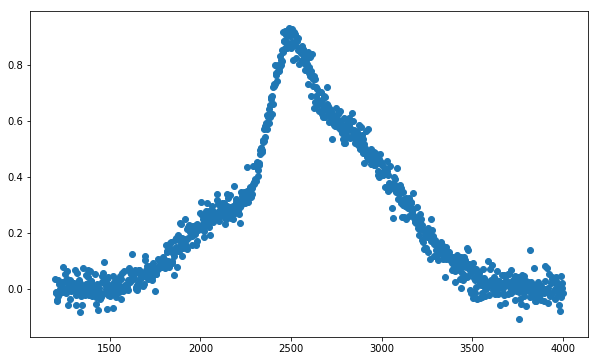

In [2]:
df = pd.read_csv('HW4_data.csv')
fig, ax = plt.subplots(1,1, figsize=(10, 6))
ax.scatter(df['0'], df['1'])
x = df['0'].values
y = df['1'].values

In [18]:
def BIC(y, yhat, k, weight = 1):
    err = y - yhat
    sigma = np.std(np.real(err))
    n = len(y)
    B = n*np.log(sigma**2) + weight*k*np.log(n)
    return B

### Problem 1 - 10 points - Complexity and Error Metrics

Implement a strategy to quantify complexity and error for a regression model. Calculate these quantities for a linear regression model and a second-order polynomial model.

#### Calculate these quantities for a linear regression model by using BIC

Linear regression:
-------------------
slope = 2.2702903993282614e-06, intercept = 0.2436134533410454, R2 = 4.781652538043968e-05
BIC value is -2637.455915818264


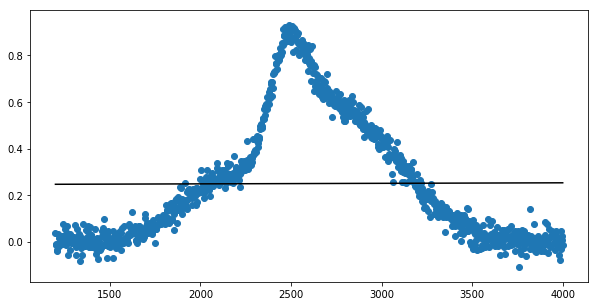

In [39]:
from sklearn.linear_model import LinearRegression
LR = LinearRegression()
x = x.reshape(-1,1) #<- this makes x a column vector
LR.fit(x,y)
m = LR.coef_[0]
b = LR.intercept_
R2 = LR.score(x,y)
print('Linear regression:')
print('-------------------')
print('slope = {}, intercept = {}, R2 = {}'.format(m,b,R2))
x = x[:,0] #<- transform back to numpy vector
fig, ax = plt.subplots(figsize=(10, 5))
ax.scatter(x,y,)
ax.plot(x, m*x+b, ls='-', color='k')

yhat = m*x+b
B = BIC(y, yhat, 2)
print('BIC value is {}'.format(B))

Text(0,0.5,'error')

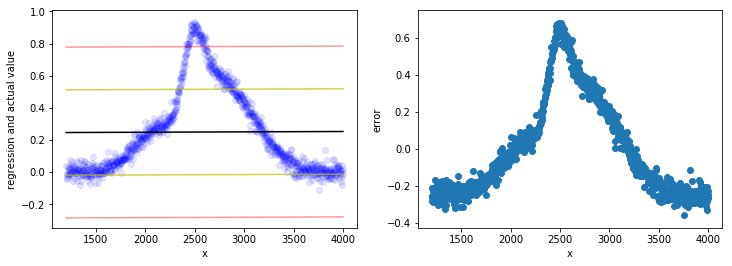

In [5]:
error = y - (m*x+b)
stdev = np.std(error)
stdev
fig, axes = plt.subplots(1,2, figsize=(12,4))
axes[0].scatter(x, y, color='b', alpha = 0.1)
axes[0].plot(x, m*x+b+2*stdev, ls='-', color='r',alpha=0.4)
axes[0].plot(x, m*x+b+stdev, ls='-', color='y',alpha=0.7)
axes[0].plot(x, m*x+b, ls='-', color='k')
axes[0].plot(x, m*x+b-stdev, ls='-', color='y', alpha=0.7)
axes[0].plot(x, m*x+b-2*stdev, ls='-', color='r', alpha=0.4)
axes[0].set_xlabel('x')
axes[0].set_ylabel('regression and actual value')
axes[1].scatter(x,error)
axes[1].set_xlabel('x')
axes[1].set_ylabel('error')



#### Calculate these quantities for a second-order polynomical model

In [6]:
params = np.polyfit(x,y,deg=3)
params

array([-1.12602449e-11, -2.79922162e-07,  1.69949184e-03, -1.83823300e+00])

Degree: 2, R2: 0.657126738882826, Stdev: 0.1555467413669961, BIC vallue:-3700.8947440853217
Coeffs: [-2.00164485627104, 0.0019145810650689438, -3.67752072051849e-07]


Text(0,0.5,'error')

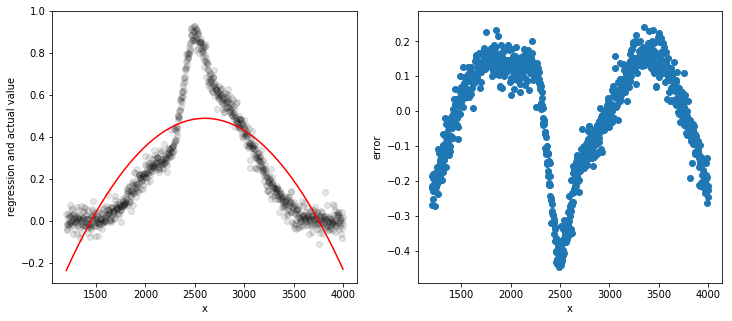

In [44]:
fig, axes = plt.subplots(1,2, figsize=(12,5))
axes[0].scatter(x,y,color='k',alpha=0.1)
colors = ['c','r','g','b','m']

def sum_squares(y_pred, y_real):
    return sum([(yi-yj)**2 for yi, yj in zip(y_pred,y_real)])

for degree in range(2,3):
    beta = np.polyfit(x,y,deg=degree)
    beta = list(beta)
    beta.reverse()
    y_pred = np.zeros_like(x)
    for i, beta_i in enumerate(beta):
        y_pred += beta_i*(x**i)
    error = y_pred - y
    SS = sum_squares(y_pred, y)
    SSM = sum_squares([y.mean()]*len(y), y)
    R2 = (SSM - SS)/SSM
    stdev = np.std(y-y_pred)
    B = BIC(y, y_pred, degree+1)
    print('Degree: {}, R2: {}, Stdev: {}, BIC vallue:{}'.format(degree, R2, stdev,B))
    print('Coeffs: {}'.format(beta))
    axes[0].plot(x, y_pred, ls='-', color=colors[degree-1])
    axes[0].set_xlabel('x')
    axes[0].set_ylabel('regression and actual value')
axes[1].scatter(x,error)
axes[1].set_xlabel('x')
axes[1].set_ylabel('error')


### Problem 2 - 20 points - Complexity Optimization

Implement a strategy to arbitrarily increase complexity. Use this strategy along with a regression model to determine the error metric as a function of the complexity metric from 1 to 100 parameter models.

In [8]:
from numpy.polynomial.legendre import legval

def fourier_basis(x, k , N):
    omega = 2*np.pi*k/N
    return np.real(np.cos(omega*x) - 1j*np.sin(omega*x))

def gaussian_basis(x, xk , sigma = 1):
    return np.exp(-((x - xk)**2/(2*sigma**2)))

def legendre_basis(x, k):
    alphas = np.zeros(k+1)
    alphas[-1] = 1
    x_normed = (x - min(x))/(max(x) - min(x))
    x_normed = x_normed*2 - 1
    return legval(x_normed, alphas)

def hinge_basis(x, xk, order):
    if order > 0:
        return np.array([max(0,xi-xk)**order for xi in x])
    else:
        return np.array([int(xi > xk)*xi**order for xi in x])

In [9]:
def expand_basis(x, basis_function, N_basis, params = {}):
    if basis_function in [gaussian_basis, hinge_basis]:
        # local basis functions
        x_basis = np.linspace(max(x), min(x),  N_basis)
        X = np.array([basis_function(x,xk, **params) for xk in x_basis]).T
    else:
        # global basis functions
        if basis_function is fourier_basis and params == {}:
            params['N'] = N_basis
        X = np.array([basis_function(x,k, **params) for k in range(0,N_basis)]).T
    return X

BIC value is -6467.449435539414


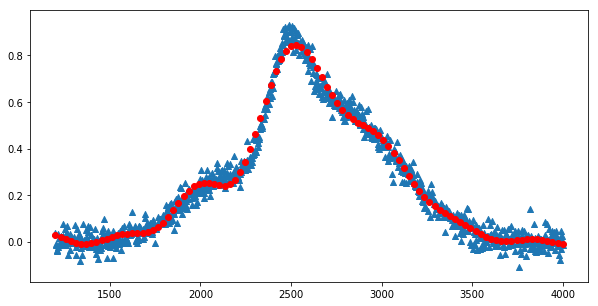

In [19]:
from sklearn import linear_model
lm = linear_model.LinearRegression(fit_intercept=False) #<- the 0th basis acts as an intercept

N = 15  # affect the value of BIC, how many data points are used
sigma = (max(x) - min(x))/N

basis = gaussian_basis   
params = {'sigma':sigma}

x_dense = np.linspace(min(x), max(x), 100)
X = expand_basis(x, basis, N, params = params)
Xd = expand_basis(x_dense, basis, N, params = params)

model = lm.fit(X,y)

yhat = model.predict(X)
yd = model.predict(Xd)
B = BIC(y, yhat, N)
print('BIC value is {}'.format(B))

fig, ax = plt.subplots(figsize=(10,5))
ax.scatter(x,y,marker='^')
ax.plot(np.real(x_dense), np.real(yd),'ro')


Now we can plot the BIC as a function of the number of parameters. 

-6807.036013070086
The best number of parameters is 21


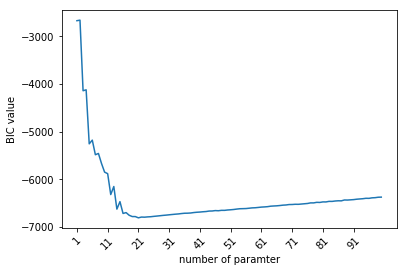

In [36]:
B_list = []
R2_list = []
N_list = range(1, 101)

#print(N_list)len(x)-1
for Ni in N_list:
    params ={'sigma':(max(x)-min(x))/Ni}
    X = expand_basis(x, basis, Ni, params=params)
    model = lm.fit(X,y)
    yhat = model.predict(X)
    R2value = lm.score(X,y)
    R2_list.append(R2value)
    Bi = BIC(y, yhat, Ni)
    B_list.append(Bi)
    
fig, ax = plt.subplots()
ax.plot(N_list, B_list)
ax.set_xticks(N_list)
plt.xticks(np.arange(min(N_list), max(N_list)+1, 10.0),rotation=45)
ax.set_xlabel('number of paramter')
ax.set_ylabel('BIC value')
print(min(B_list))
N_best = np.argmin(B_list)+1
print('The best number of parameters is {}'.format(N_best))


Low BIC value, higher R2 value, better model


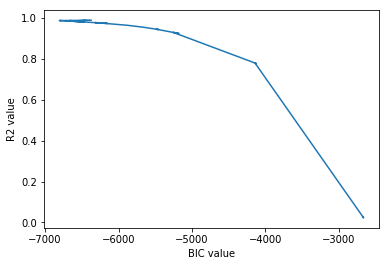

In [46]:
fig, ax = plt.subplots()
ax.plot(B_list, R2_list)
ax.set_xlabel('BIC value')
ax.set_ylabel('R2 value')
print('Low BIC value, higher R2 value, better model')

Let's try cross-validation instead:

In [47]:
from sklearn.model_selection import cross_val_score

def std_err(lm, X, y):
    yhat = lm.predict(X)
    return np.mean(np.abs(y - yhat))

def CVscore(model, X, y, cv=10):
    model.fit(X, y)
    scores = cross_val_score(model, X, y, cv=len(y)-1, scoring=std_err)  # abs_Err
    #print(scores.min(), scores.max())
    return np.mean(scores)

In [ ]:
CV_list = []
N_list = range(1, 100)
for Ni in N_list:
    X = expand_basis(x, basis, Ni, params=params)
    CV = CVscore(lm, X,y)
    CV_list.append(CV)
    
fig, ax = plt.subplots()
ax.plot(N_list, CV_list)
ax.set_xticks(N_list)
print(max(CV_list))
plt.xticks(np.arange(min(N_list), max(N_list)+1, 10.0),rotation=45)
ax.set_xlabel('number of paramter')
ax.set_ylabel('CV value')

### Problem 3 - 20 points - Refinement and Interpretation

Utilize and/or refine the complexity/error metrics and regression model in order to determine:

1) The number of peaks in the spectra
2) The locations of peaks in the spectra
3) The area of the peaks in the spectra

Note: There is a right answer here since this is synthetic data, but you won't be graded on whether or not you get it right. As long as you illustrate a reasonable approach it is sufficient.

In [91]:
def curve_function(x, *params):
    N = int(len(params)/3) # we will pass a vector of alpha, mean, stdev
    alpha=params[:N]
    mu=params[N:2*N]
    sigma=params[2*N:3*N]
    y = np.zeros_like(x)
    for i in range(0,N):
        y += alpha[i]*gaussian_basis(x, mu[i], sigma[i])
    return y

[0.3825662227381609, 0.6129802545663365, 0.9096171038665292, 3741.776197257678, 3552.6734102051114, 3031.3539962090977, 3.314723750158688, 195.57873585779853, 188.58581884904788]
----------------------
Peak Intensities : [0.01268583 0.0416973  0.74131517]
Peak Positions : [3704.70456188 3941.1580114  2607.26232372]
Peak Widths : [ 11.74578647  -3.85715204 370.46113849]
[1.09967188e+01 3.89781571e+00 6.39246079e+05]


Text(0,0.5,'Intensity [a.u.]')

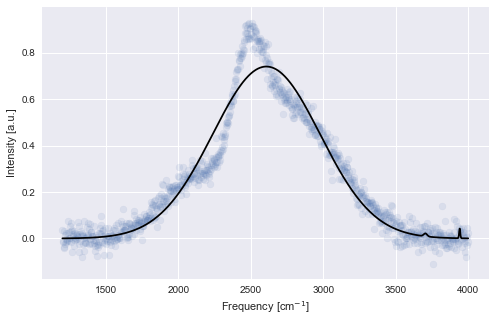

In [95]:
from scipy.optimize import curve_fit


#p0 = np.random.rand(9)
p0 = list(np.random.rand(3)) + list(4000*(np.random.rand(3))) + list(200*np.random.rand(3))
print(p0)
#p0 = [1,1,1, 2200, 2500, 2800, 300, 100, 250]

params, pcov = curve_fit(curve_function, x, y, p0 = p0)
print('----------------------')
print("Peak Intensities : {}".format(params[:3])) # alpha
print("Peak Positions : {}".format(params[3:6])) #mu
print("Peak Widths : {}".format(params[6:]))  #sigma

#area = 2*np.pi.sigma**2*alpha

print
area = 2*np.pi*params[6:]**2*params[:3]
print(area)

fig, ax = plt.subplots(figsize=(8,5))
ax.scatter(x,y,alpha=0.1)
ax.plot(x, curve_function(x, *params), '-k')

ax.set_xlabel("Frequency [cm$^{-1}$]")
ax.set_ylabel("Intensity [a.u.]")


## Part 2:

In this part you will work with the MNIST dataset of hand-written digits. You will utilize kernel-based classification algorithms to classify the data, and will tune hyper-parameters using cross-validation. You may recycle code from the lectures to achieve this goal.

You should use at least 1500 MNIST images, but may use more if you would like.

In [50]:
from mnist import MNIST
mndata = MNIST('./mnist')
images, labels = mndata.load_training()
images = np.array(images)
images_subset = images[:1500,:] #<- take the first 1000 images
images_subset.shape
images_subset[0].shape


(784,)

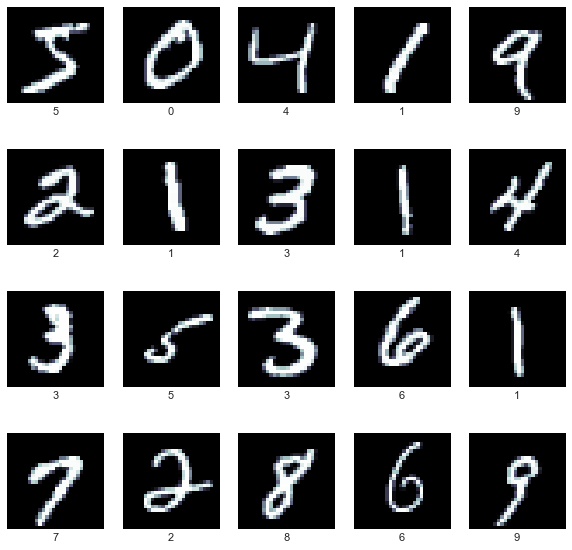

In [51]:

fig, ax = plt.subplots(4,5, figsize=(10,10))
for i, axi in enumerate(ax.flat):
    axi.imshow(images_subset[i].reshape(28,28), cmap='bone')
    axi.set(xticks=[], yticks=[],xlabel=labels[:1500][i])
    

### Problem 4 - 10 points - Feature selection

Load in the MNIST dataset and decide on feature vectors to represent the data. You should quantitatively justify the choice of feature vector in some way. For example, describe how much variance your feature set captures.

(1500, 784)
137 Components can capture 95% variance


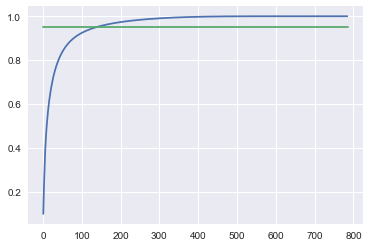

In [83]:
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline

pca = PCA(n_components=784)
Xt = pca.fit_transform(images_subset)
print(Xt.shape)
fig, ax = plt.subplots()
ev = pca.explained_variance_ratio_

a = sum(np.cumsum(ev)<0.95)+1

ax.plot(range(1, len(ev)+1), np.cumsum(ev))
ax.plot([1,len(ev)+1],[0.95,0.95])
print("{} Components can capture 95% variance".format(a))

### Problem 5 - 20 points - Kernel-based classification

Use a kernel-based classification model to classify the digits from 1-10. Hold out at least 30$\%$ of the original data as a validation set, and report the confusion matrix for the validation set.

(250, 784)


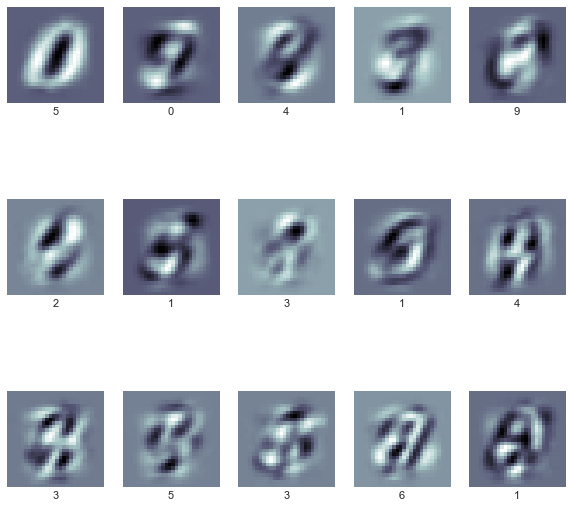

In [53]:
pca = PCA(n_components=250)
PCA_mnist = pca.fit_transform(images_subset)
pca_df = pd.DataFrame(PCA_mnist)
pca_df['label'] = labels[:1500]

print(pca.components_.shape)
fig, ax = plt.subplots(3, 5, figsize=(10,10))

for i, axi in enumerate(ax.flat):
    axi.imshow(pca.components_[i].reshape(28, 28),cmap='bone')
    axi.set(xticks=[], yticks=[],
            xlabel=pca_df['label'][i])

In [89]:
from sklearn.pipeline import make_pipeline

pca = PCA(n_components=137)
svc = SVC(kernel='rbf', class_weight='balanced')  #, , C=1000, gamma=1e-8
model = make_pipeline(pca, svc)

Xt = pca.fit_transform(images_subset)

from sklearn.model_selection import train_test_split
Xtrain, Xtest, ytrain, ytest = train_test_split(Xt, labels[:1500], test_size=0.3)

model.fit(Xtrain, ytrain)
yfit = model.predict(Xtest)

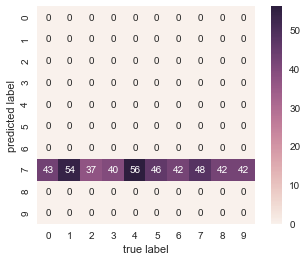

In [90]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

fig, ax = plt.subplots()
mat = confusion_matrix(ytest, yfit)
sns.heatmap(mat.T, square = True, annot=True, fmt='d')
#ax.imshow(mat.T,interpolation='nearest')

ax.set_xlabel('true label')
ax.set_ylabel('predicted label');


### Problem 6 - 20 points - Hyperparameter tuning

Use grid-based cross-validation to determine at least 2 hyperparameters of your kernel-based classifier. Report the parameters of the best model, and the confusion matrix of the best model on the validation set.

In [77]:
from sklearn.model_selection import GridSearchCV
param_grid = {'svc__C': [1, 5, 10, 50, 100],
              'svc__gamma': [1e-12, 1e-10, 1e-8, 1e-6, 1e-4, 1e-2]}
grid = GridSearchCV(model, param_grid)

%time grid.fit(Xtrain, ytrain)
print('The paramters of the best model are {}'.format(grid.best_params_))


CPU times: user 45.6 s, sys: 4.87 s, total: 50.4 s
Wall time: 28.8 s
The paramters of the best model are {'svc__C': 100, 'svc__gamma': 1e-08}


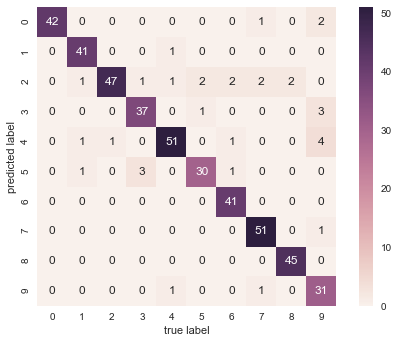

In [71]:

from sklearn.metrics import confusion_matrix

model = grid.best_estimator_
yfit = model.predict(Xtest)

fig, ax = plt.subplots()
mat = confusion_matrix(ytest, yfit)
sns.heatmap(mat.T, square = True, annot=True, fmt='d')

#ax.imshow(mat.T)

ax.set_xlabel('true label')
ax.set_ylabel('predicted label');